In [1]:
import os
import itertools
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# Quantitative Results
We use epoch loss and accuracy plot, confusion matrix, and roc curve

In [3]:
model = load_model('../outputs/final_model.h5')

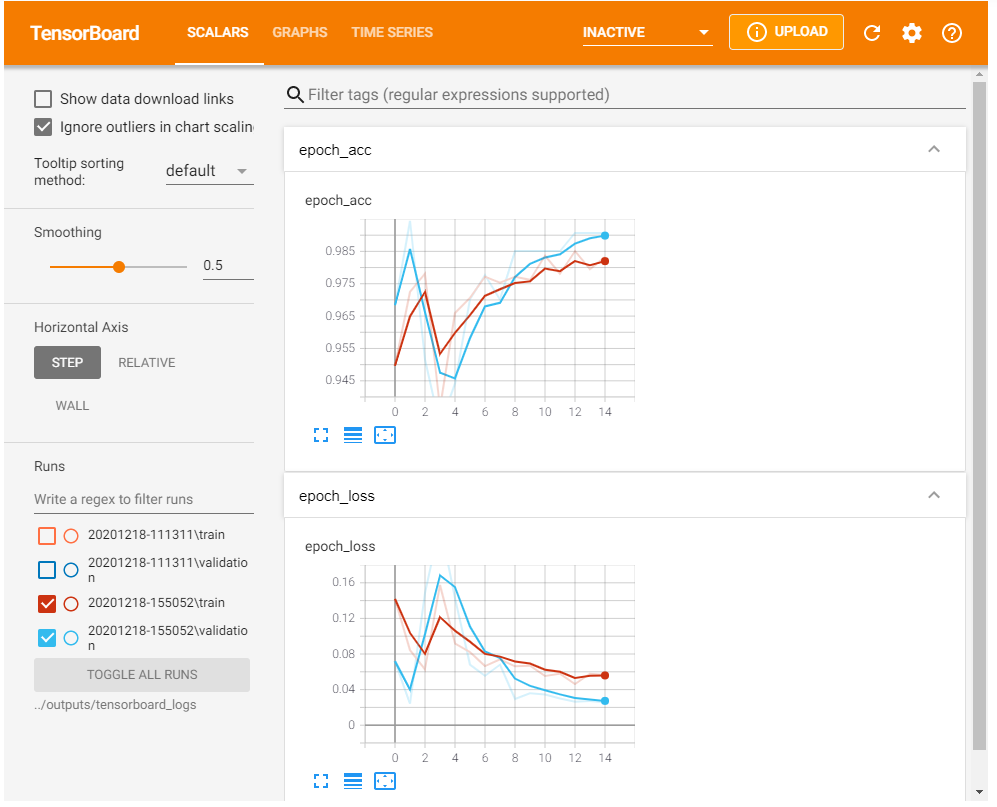

In [6]:
load_img('../outputs/epoch_plot.png')

The loss and accuracy epoch plot is made with TensorBoard. The head of model is trained for 3 epochs then train the last few inception block until 15 epochs. Overall, the epoch plot looks good with a good fit. (No underfit or overfit). The small spike at epoch 3 is because we unfreeze the last few inception block and the parameters are retrained. The final validation loss is 0.0258 and the final validation accuracy is 0.9907.

In [4]:
image_dir = '../data/clahe_applied/'
target_size = (299, 299)

X, y = [], []
classes = {0: 'NORMAL', 1: 'COVID-19'}
rev_class = {v:k for k, v in classes.items()}
for _class in os.listdir(image_dir):
    for img_path in os.listdir(os.path.join(image_dir, _class)):
        X.append(img_to_array(load_img(os.path.join(image_dir, _class, img_path), target_size=target_size)))
        y.append(rev_class[_class])
X = np.array(X)
y = np.array(y)

In [13]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
y_prob = model.predict(datagen.flow(X, shuffle=False, batch_size=1))

<tf.Tensor: shape=(), dtype=float32, numpy=0.98695004>

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, axis=1):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = np.nan_to_num(cm)
    if normalize:
        if axis==1:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=0)
    cm = np.nan_to_num(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=8)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
y_pred = (y_prob > 0.5).astype(int)

In [20]:
class_label = list(classes.values())

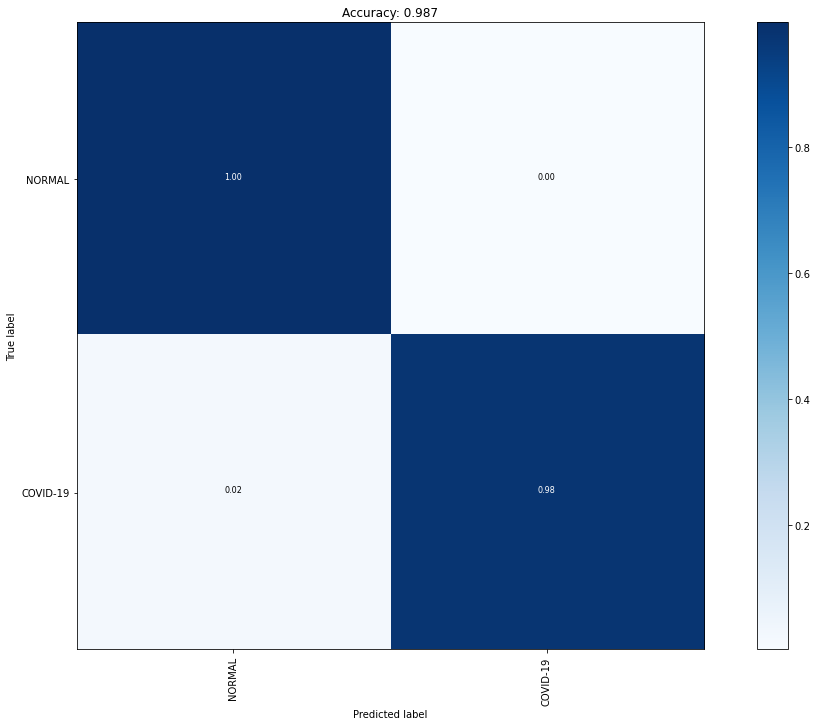

              precision    recall  f1-score   support

      NORMAL      0.977     0.998     0.987      1341
    COVID-19      0.998     0.976     0.987      1341

    accuracy                          0.987      2682
   macro avg      0.987     0.987     0.987      2682
weighted avg      0.987     0.987     0.987      2682



In [27]:
# plotting confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(15,10))
accuracy = accuracy_score(y, y_pred)
plot_confusion_matrix(cm, class_label, normalize=True, title='Accuracy: {0:.3f}'.format(accuracy))
plt.show()
print(classification_report(y, y_pred, digits=3, target_names=class_label))

From the confusion matrix, we can see that only 2% of the time when our model predicts NORMAL class, it is a wrong prediction.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=1.000


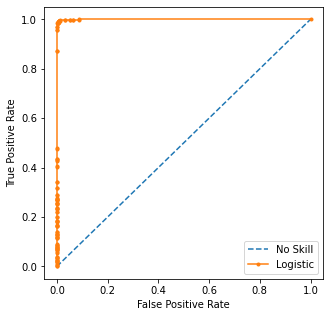

In [30]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y))]

# calculate scores
ns_auc = roc_auc_score(y, ns_probs)
lr_auc = roc_auc_score(y, y_prob)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(5, 5))
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

To interpret a ROC curve, the curve closer to the top-left corner indicate a better performance, while closer to the diagonal means less accurate model. The graph is expected given the high precision and recall rate of our model.

# Qualitative Results
We use guided Grad-CAM to visualize class activation. This is to make sure the trained model is looking at the "correct" feature to predict whether an xray image is covid-19 or normal. 

In [88]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad


class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads
    
    
def gradcam(img, last_conv_layer_model, classifier_model):
    # calculate gradient from last convolution layer
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)

    grads = tape.gradient(preds, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # Average over all the filters to get a single 2D array
    gradcam = np.mean(last_conv_layer_output, axis=-1)
    # Clip the values (equivalent to applying ReLU)
    # and then normalise the values
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, target_size)
    return gradcam

def guided_backprop(img, model, layer_name='mixed10'):
    gb = GuidedBackprop(model, layer_name)
    saliency_map = gb.guided_backprop(img).numpy()
    return saliency_map

def guided_gradcam(img, last_conv_layer_model, classifier_model, saliency_map):
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)

    grads = tape.gradient(preds, last_conv_layer_output)[0]
    last_conv_layer_output = last_conv_layer_output[0]
    guided_grads = (
        tf.cast(last_conv_layer_output > 0, "float32")
        * tf.cast(grads > 0, "float32")
        * grads
    )
    pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
    guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)
    for i, w in enumerate(pooled_guided_grads):
        guided_gradcam += w * last_conv_layer_output[:, :, i]
    guided_gradcam = cv2.resize(guided_gradcam.numpy(), target_size)
    guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
    guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
        guided_gradcam.max() - guided_gradcam.min()
    )
    saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)
    
    return saliency_map

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def plot_map(img, grad_cam, guided_bp, gg_cam):
    # function to plot the cam results
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Input')
    axes[1].imshow(img)
    i = axes[1].imshow(grad_cam, cmap="jet",alpha=0.8)
    fig.colorbar(i, ax=axes[1])
    axes[1].axis('off')
    axes[1].set_title('Grad-CAM')
    axes[2].imshow(np.flip(deprocess_image(guided_bp), -1))
    axes[2].axis('off')
    axes[2].set_title('Guided Backprop')
    axes[3].imshow(np.flip(deprocess_image(gg_cam), -1))
    axes[3].axis('off')
    axes[3].set_title('GG-CAM')

In [15]:
# define the last convolution layer
last_conv_layer = model.get_layer("mixed10")
last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["global_average_pooling2d", "dense", "dense_1"]:
    x = model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

## Guided GradCAM
Guided gradient-weighted class activation mapping is a method to visualize region of inputs that are "important" for getting the final class predictions. GradCAM produces a heatmap that indicates important regions while Guided GradCAM combines the heatmap with a saliency map produced by guided backprop.

We can observe that some of the COVID-19 images has boxes that indicates the effects of COVID-19 disease (fluid, debris, pneumonia) and our model successfully learnt how to identify those effects.

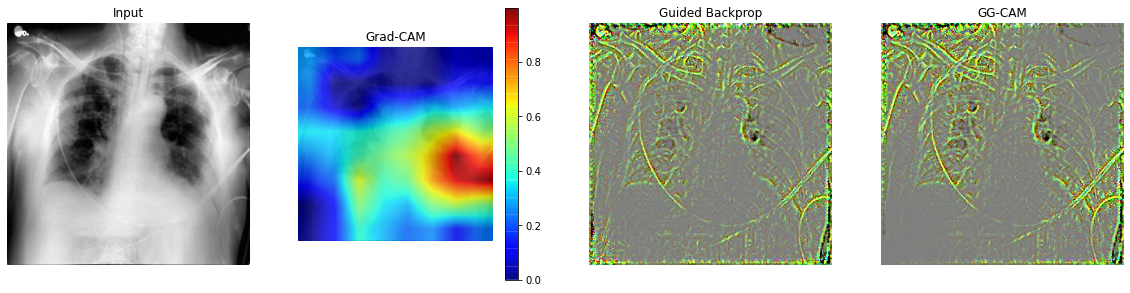

In [89]:
img_path = os.path.join(image_dir, 'COVID-19', 'COVID-19 (1).png')
img = img_to_array(load_img(img_path, target_size=target_size))
img = preprocess_input(np.expand_dims(img, axis=0))
_img = load_img(img_path, target_size=target_size)
grad_cam = gradcam(img, last_conv_layer_model, classifier_model)
guided_bp = guided_backprop(img, model)
gg_cam = guided_gradcam(img, last_conv_layer_model, classifier_model, guided_bp)
plot_map(_img, grad_cam, guided_bp, gg_cam)

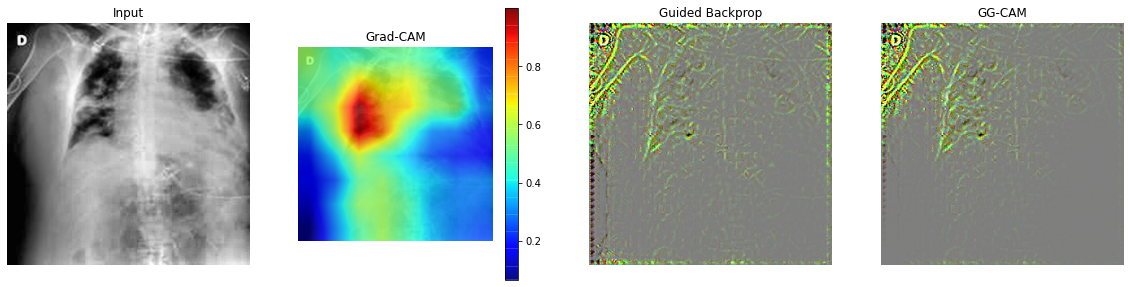

In [90]:
img_path = os.path.join(image_dir, 'COVID-19', 'COVID-19 (99).png')
img = img_to_array(load_img(img_path, target_size=target_size))
img = preprocess_input(np.expand_dims(img, axis=0))
_img = load_img(img_path, target_size=target_size)
grad_cam = gradcam(img, last_conv_layer_model, classifier_model)
guided_bp = guided_backprop(img, model)
gg_cam = guided_gradcam(img, last_conv_layer_model, classifier_model, guided_bp)
plot_map(_img, grad_cam, guided_bp, gg_cam)

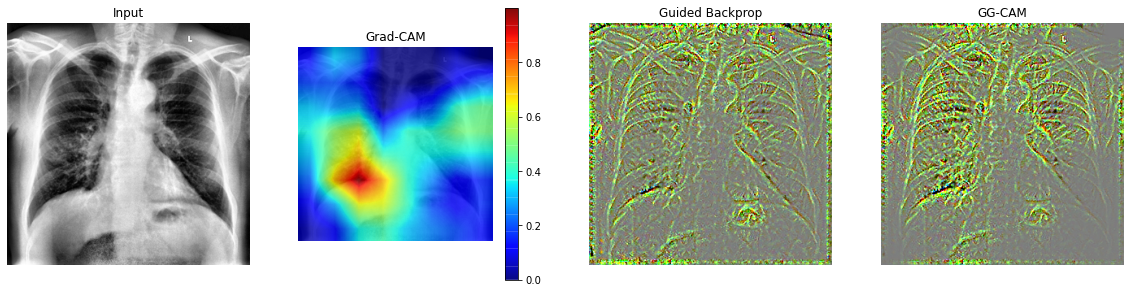

In [91]:
img_path = os.path.join(image_dir, 'COVID-19', 'COVID-19 (999).png')
img = img_to_array(load_img(img_path, target_size=target_size))
img = preprocess_input(np.expand_dims(img, axis=0))
_img = load_img(img_path, target_size=target_size)
grad_cam = gradcam(img, last_conv_layer_model, classifier_model)
guided_bp = guided_backprop(img, model)
gg_cam = guided_gradcam(img, last_conv_layer_model, classifier_model, guided_bp)
plot_map(_img, grad_cam, guided_bp, gg_cam)

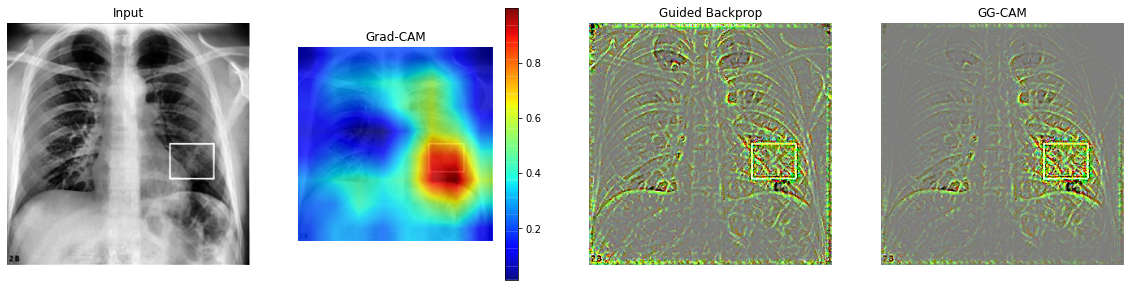

In [93]:
img_path = os.path.join(image_dir, 'COVID-19', 'COVID-19 (1111).png')
img = img_to_array(load_img(img_path, target_size=target_size))
img = preprocess_input(np.expand_dims(img, axis=0))
_img = load_img(img_path, target_size=target_size)
grad_cam = gradcam(img, last_conv_layer_model, classifier_model)
guided_bp = guided_backprop(img, model)
gg_cam = guided_gradcam(img, last_conv_layer_model, classifier_model, guided_bp)
plot_map(_img, grad_cam, guided_bp, gg_cam)